# 5.2 填充和步幅
在上一节的例子里，我们使用高和宽为3的输入与高和宽为2的卷积核得到高和宽为2的输出。一般来说，假设输入形状是$n_h×n_w$，卷积核窗口形状是$k_h×k_w$，那么输出形状将会是

$$(n_h-k_h+1)×(n_w-k_w+1).$$

所以卷积层的输出形状由输入形状和卷积核窗口形状决定。本节我们将介绍卷积层的两个超参数，即填充和步幅。它们可以对给定形状的输入和卷积核改变输出形状。

## 5.2.1 填充
填充(padding)是指在输入高和宽的两侧填充元素(通常是0元素)。下图我们在原输入高和宽的两侧分别添加了值为0的元素，使得输入高和宽从3变成了5，并导致输出高和宽由2增加到4。下图中的阴影部分为第一个输出元素及其计算所使用的输入和核数组元素：
$$0×0+0×1+0×2+0×3=0$$

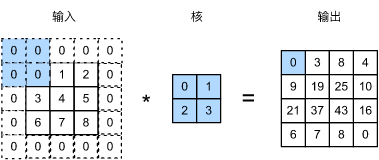
一般来说，如果在高的两侧一共填充$p_h$行，在宽的两侧一共填充$p_w$列，那么输出形状将会是

$$(n_h-k_h+p_h+1)×(n_w-k_w+p_w+1)$$

也就是说，输出的高和宽会分别增加$p_h$和$p_w$。

在很多情况下，我们会设置$p_h=k_h-1$和$p_w=k_w-1$来使输入和输出具有相同的高和宽。这样方便在构造网络时推测每个层的输出形状。假设这里$k_h$为奇数，我们会在高的两侧分别填充$p_h/2$行。如果$k_h$是偶数，一种可能是在输入的顶端一侧填充$\lceil p_h/2\rceil$行，而在底端一侧填充$\lfloor p_h/2\rfloor$行。在宽的两侧填充同理。

卷积神经网络经常使用奇数高宽的卷积核，如1、3、5和7，所以两端上的填充个数相等。对任意的二维数组`X`，设它的第`i`行第`j`列的元素为`X[i,j]`。当两端上的填充个数相等，并使输入和输出具有相同的高和宽时，我们就知道输出`Y[i,j]`是由输入以`X[i,j]`为中心的窗口同卷积核进行互相关计算得到的。

下面的例子里我们创建一个高和宽为3的二维卷积层，然后设输入高和宽两侧的填充数分别为1。给定一个高和宽为8的输入，我们发现输出的高和宽也是8。

In [3]:
import torch
from torch import nn

# 定义一个函数来计算卷积层。它对输入和输出做相应的升维和降维
def comp_conv2d(conv2d, X):
    # (1, 1)代表批量大小和通道数均为 1
    X = X.view((1, 1) + X.shape)
    Y = conv2d(X)
    return Y.view(Y.shape[2:])  # 排除不关心的前两维：批量和通道

# 注意这里是两侧分别填充1行或列，所以在两侧一共填充2行或列
conv2d = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1)

X = torch.rand(8, 8)
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

当卷积核的高和宽不同时，我们也可以通过设置高和宽上不同的填充数使输出和输入具有相同的高和宽

In [14]:
# 使用高为5、宽为3的卷积核。在高和宽两侧的填充数分别为2和1
conv2d = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

## 5.2.2 步幅
卷积窗口从输入数组的最左上方开始，按从左往右、从上往下的顺序，依次在输入数组上滑动。我们将每次滑动的行数和列数称为步幅（stride）。

目前我们看到的例子里，在高和宽两个方向上步幅均为1。我们也可以使用更大步幅。图5.3展示了在高上步幅为3、在宽上步幅为2的二维互相关运算。可以看到，输出第一列第二个元素时，卷积窗口向下滑动了3行，而在输出第一行第二个元素时卷积窗口向右滑动了2列。当卷积窗口在输入上再向右滑动2列时，由于输入元素无法填满窗口，无结果输出。图5.3中的阴影部分为输出元素及其计算所使用的输入和核数组元素：

$$0×0+0×1+1×2+2×3=8、0×0+6×1+0×2+0×3=6$$

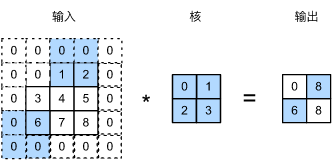

一般来说，当高上步幅为$s_h$，宽上步幅为$s_w$时，输出形状为

$$\lfloor(n_h-k_h+p_h+s_h)/s_h\rfloor \times \lfloor(n_w-k_w+p_w+s_w)/s_w\rfloor.$$

如果设置$p_h=k_h-1$和$p_w=k_w-1$，那么输出形状将简化为$\lfloor(n_h+s_h-1)/s_h\rfloor \times \lfloor(n_w+s_w-1)/s_w\rfloor$。更进一步，如果输入的高和宽能分别被高和宽上的步幅整除，那么输出形状将是 $(n_h/s_h) \times (n_w/s_w)$。

下面我们令高和宽上的步幅均为2，从而使输入的高和宽减半。

In [15]:
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

接下来是一个稍微复杂点儿的例子。

In [19]:
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 3), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 3])

为了表述简洁，当输入的高和宽两侧的填充数分别为$p_h$和$p_w$时，我们称填充为$(p_h, p_w)$。特别地，当$p_h = p_w = p$时，填充为$p$。当在高和宽上的步幅分别为$s_h$和$s_w$时，我们称步幅为$(s_h, s_w)$。特别地，当$s_h = s_w = s$时，步幅为$s$。在默认情况下，填充为0，步幅为1。

# 小结
* 填充可以增加输出的高和宽。这常用来使输出与输入具有相同的高和宽。
* 步幅可以减小输出的高和宽，例如输出的高和宽仅为输入的高和宽的$1/n$（$n$为大于1的整数）。